# **Applying Machine Learning Techniques to improve Linux Process Scheduling**

## Import neccessary libraries

In [706]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# # Data Collection

In [707]:
# Load the dataset
df = pd.read_csv(r"Dataset\Linux_Scheduling_Dataset.csv")
df

,InputSize,ProgramSize,BSS,RoData,Text,InputType,STSclass
0,7370,7851,19,4492,18371,Reverse Sorted,Short burst
1,960,26421,667,3717,36297,Sorted,Medium burst
2,5490,19840,748,4880,21996,Sorted,Medium burst
3,5291,15401,757,1326,29753,Sorted,Medium burst
4,5834,11138,473,592,46174,Constant,Long burst
...,...,...,...,...,...,...,...
9994,1209,23305,606,4562,17092,Random,Short burst
9995,7029,30944,720,488,36654,Reverse Sorted,Long burst
9996,1350,20643,141,214,13451,Reverse Sorted,Short burst
9997,8277,10792,597,3387,14991,Random,Short burst


### Analyze the data

In [708]:
df.shape

(9999, 7)

In [709]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InputSize    9999 non-null   int64 
 1   ProgramSize  9999 non-null   int64 
 2   BSS          9999 non-null   int64 
 3   RoData       9999 non-null   int64 
 4   Text         9999 non-null   int64 
 5   InputType    9999 non-null   object
 6   STSclass     9999 non-null   object
dtypes: int64(5), object(2)
memory usage: 546.9+ KB


In [710]:
df.describe()

,InputSize,ProgramSize,BSS,RoData,Text
count,9999.000000,9999.00000,9999.000000,9999.000000,9999.000000
mean,5013.664266,25000.09991,505.140914,2540.044804,25267.663166
std,2852.979722,14233.19792,286.488796,1422.095308,14091.471860
min,101.000000,505.00000,10.000000,50.000000,1001.000000
25%,2562.500000,12708.50000,259.000000,1317.000000,13112.500000
50%,4992.000000,24646.00000,506.000000,2555.000000,25238.000000
75%,7450.500000,37308.00000,750.500000,3761.000000,37409.000000
max,10000.000000,50000.00000,1000.000000,4998.000000,49996.000000


In [711]:
df.columns

Index(['InputSize', 'ProgramSize', 'BSS', 'RoData', 'Text', 'InputType',
       'STSclass'],
      dtype='object')

### **Dataset Description:  Linux Process Scheduling Dataset**

This dataset contains **9999 samples** and represents **process execution characteristics** to predict the best **Special Time Slice (STS) category**.

---

## **1. Dataset Summary**
| Feature Name     | Data Type | Description |
|-----------------|-----------|-------------|
| **Input_Size**   | Integer | The size of the input given to the process (Range: **100 - 2000**). |
| **Program_Size** | Integer | The total size of the program in bytes (Range: **1000 - 50000**). |
| **BSS_Size**     | Integer | Size of the **BSS (Block Started by Symbol) section**, which contains uninitialized global variables (Range: **500 - 10000**). |
| **RoData_Size**  | Integer | Size of the **Read-Only Data section** (Range: **100 - 5000**). |
| **Text_Size**    | Integer | The size of the executable instruction section in bytes (Range: **500 - 20000**). |
| **Input_Type**   | Categorical | The type of input given to the process (e.g., **Numeric, Alphanumeric, Binary**). |
| **STS_Class** (Target Variable) | Categorical | The predicted **CPU time slice allocation category**. |

---

## **2. Target Variable Distribution (STS_Class)**

The **STS_Class** (Special Time Slice Class) is the **classification label**:

| Class | CPU Burst Time (Ticks) | Description                                                   |
|-------|------------------------|---------------------------------------------------------------|
| Very short burst     | 0–99 ticks             | Suitable for I/O-bound or highly interactive tasks. |
| Short burst     | 100–199 ticks          | Ideal for lightweight CPU tasks with frequent preemption. |
| Medium burst     | 200–299 ticks          | Balanced for mixed CPU/I/O workloads (most common class). |
| Long burst     | 300–399 ticks          | For CPU-intensive tasks needing sustained execution. |
| Very long burst     | 400–500 ticks          | Reserved for heavy CPU-bound processes (e.g., matrix math). |

This classification helps in optimizing **Linux CPU scheduling** by dynamically predicting the required CPU burst time.

In [712]:
df.duplicated().sum()

0

In [713]:
df.isnull().sum()

InputSize      0
ProgramSize    0
BSS            0
RoData         0
Text           0
InputType      0
STSclass       0
dtype: int64

In [714]:
df["InputType"].value_counts()

InputType
Sorted            2525
Random            2503
Constant          2490
Reverse Sorted    2481
Name: count, dtype: int64

In [715]:
# Target value counts
df["STSclass"].value_counts()

STSclass
Medium burst        3670
Long burst          2590
Short burst         2545
Very long burst      659
Very short burst     535
Name: count, dtype: int64

This is a imbalanced dataset. So we need to balance this first

### Label Encoding

In [716]:
# label encoding the data.
# Store original column names
from sklearn.preprocessing import LabelEncoder
original_columns = df.select_dtypes(include='object').columns

# Initialize LabelEncoder
label_encoders = {}

# Apply LabelEncoder to each categorical variable
for col in original_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Print the mapping between original categories and numerical labels
for col, encoder in label_encoders.items():
    print(f"Mapping for column '{col}':")
    for label, category in enumerate(encoder.classes_):
        print(f"Label {label}: {category}")

Mapping for column 'InputType':
Label 0: Constant
Label 1: Random
Label 2: Reverse Sorted
Label 3: Sorted
Mapping for column 'STSclass':
Label 0: Long burst
Label 1: Medium burst
Label 2: Short burst
Label 3: Very long burst
Label 4: Very short burst


## SMOTE

In [717]:
# Separating features and target variable
X = df.drop(columns=["STSclass"])  # Features
y = df["STSclass"]  # Target

In [718]:
# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [719]:
X_train

,InputSize,ProgramSize,BSS,RoData,Text,InputType
2079,7254,6939,867,925,9871,1
8022,5535,39049,298,1752,41315,2
2964,6726,10919,552,3986,20232,2
7565,8575,15226,341,842,10568,3
3059,7637,34692,605,3960,9312,0
...,...,...,...,...,...,...
7894,128,39116,611,2423,2616,3
5114,1020,30196,14,461,17917,3
1349,906,1591,192,1562,29914,3
4910,3967,13442,199,3781,16098,0


In [720]:
X_test

,InputSize,ProgramSize,BSS,RoData,Text,InputType
7328,7930,30215,825,185,40299,3
2341,6743,47315,207,2331,30989,2
3793,3358,17075,314,785,36129,1
8445,6400,49034,353,1258,15206,1
6159,6501,20023,340,3913,4739,3
...,...,...,...,...,...,...
1425,2239,20579,522,1754,2992,3
2673,9741,46150,792,589,20009,1
864,946,47542,195,1842,4630,1
1552,5209,5097,418,3985,30984,2


In [721]:
y_train

2079    2
8022    0
2964    2
7565    2
3059    1
       ..
7894    2
5114    1
1349    2
4910    2
5173    2
Name: STSclass, Length: 7999, dtype: int32

In [722]:
y_test

7328    0
2341    0
3793    1
8445    1
6159    2
       ..
1425    4
2673    0
864     2
1552    1
853     2
Name: STSclass, Length: 2000, dtype: int32

In [723]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to balance the target classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [724]:
X_train_resampled

,InputSize,ProgramSize,BSS,RoData,Text,InputType
0,7254,6939,867,925,9871,1
1,5535,39049,298,1752,41315,2
2,6726,10919,552,3986,20232,2
3,8575,15226,341,842,10568,3
4,7637,34692,605,3960,9312,0
...,...,...,...,...,...,...
14675,4815,6451,922,3255,1720,1
14676,9446,8908,348,3011,2465,2
14677,2104,1835,707,1347,5696,1
14678,3857,2823,621,3545,2364,3


In [725]:
y_train_resampled

0        2
1        0
2        2
3        2
4        1
        ..
14675    4
14676    4
14677    4
14678    4
14679    4
Name: STSclass, Length: 14680, dtype: int32

In [726]:
# Display class distribution after SMOTE
y_train_resampled.value_counts()

STSclass
2    2936
0    2936
1    2936
3    2936
4    2936
Name: count, dtype: int64

# # Algorithm Implemendation

In [727]:
# Initialize Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
# dt_model = DecisionTreeClassifier()
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_split=20, min_samples_leaf=10)

# Model Training
dt_model.fit(X_train_resampled, y_train_resampled)

# Model testing
y_pred_dt = dt_model.predict(X_test)

# Classification report and confusion matrix
dt_classification_report = classification_report(y_test, y_pred_dt)
print("Classification report for Decision Tree:")
print(dt_classification_report)

# Confusion matrix
# Compute confusion matrix
dt_confusion_matrix = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix for Decision Tree:")
print(dt_confusion_matrix)

Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       518
           1       0.76      0.70      0.73       734
           2       0.73      0.79      0.76       509
           3       0.66      0.92      0.77       132
           4       0.68      0.75      0.71       107

    accuracy                           0.74      2000
   macro avg       0.72      0.77      0.74      2000
weighted avg       0.74      0.74      0.74      2000

Confusion Matrix for Decision Tree:
[[361  96   0  61   0]
 [103 511 120   0   0]
 [  0  68 403   0  38]
 [ 11   0   0 121   0]
 [  0   0  27   0  80]]


In [728]:
# Initialize Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()

# Model Training
rf_model.fit(X_train_resampled, y_train_resampled)

# Model testing
y_pred_rf = rf_model.predict(X_test)

# Classification report and confusion matrix
rf_classification_report = classification_report(y_test, y_pred_rf)
print("Classification report for Random Forest:")
print(rf_classification_report)

# Confusion matrix
# Compute confusion matrix
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest:")
print(rf_confusion_matrix)

Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       518
           1       0.95      0.94      0.95       734
           2       0.95      0.96      0.95       509
           3       0.92      0.92      0.92       132
           4       0.92      0.93      0.92       107

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Confusion Matrix for Random Forest:
[[488  20   0  10   0]
 [ 26 692  16   0   0]
 [  0  13 487   0   9]
 [ 10   0   0 122   0]
 [  0   0   8   0  99]]


In [729]:
# Initialize Random Stacking Classifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define the base learners and the meta-learner
estimators = [
    ('rf', RandomForestClassifier()),
    ('dt', DecisionTreeClassifier())
]
sc_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Model Training
sc_model.fit(X_train_resampled, y_train_resampled)

# Model testing
y_pred_sc = sc_model.predict(X_test)

# Classification report and confusion matrix
sc_classification_report = classification_report(y_test, y_pred_sc)
print("Classification report for Stacking Classifier:")
print(sc_classification_report)

# Confusion matrix
# Compute confusion matrix
sc_confusion_matrix = confusion_matrix(y_test, y_pred_sc)
print("Confusion Matrix for Stacking Classifier:")
print(sc_confusion_matrix)

Classification report for Stacking Classifier:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       518
           1       0.96      0.96      0.96       734
           2       0.96      0.97      0.96       509
           3       0.93      0.90      0.92       132
           4       0.96      0.93      0.95       107

    accuracy                           0.95      2000
   macro avg       0.95      0.94      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Confusion Matrix for Stacking Classifier:
[[491  18   0   9   0]
 [ 17 703  14   0   0]
 [  0  13 492   0   4]
 [ 13   0   0 119   0]
 [  0   0   7   0 100]]


In [730]:
# Initialize Random XGBoost Classifier
from xgboost import XGBClassifier
xgb_model = XGBClassifier()

# Model Training
xgb_model.fit(X_train_resampled, y_train_resampled)

# Model testing
y_pred_xgb = xgb_model.predict(X_test)

# Classification report and confusion matrix
xgb_classification_report = classification_report(y_test, y_pred_xgb)
print("Classification report for XGBClassifier:")
print(xgb_classification_report)

# Confusion matrix
# Compute confusion matrix
xgb_confusion_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix for XGBClassifier:")
print(xgb_confusion_matrix)

Classification report for XGBClassifier:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       518
           1       0.96      0.95      0.96       734
           2       0.97      0.96      0.97       509
           3       0.96      0.98      0.97       132
           4       0.95      0.98      0.96       107

    accuracy                           0.96      2000
   macro avg       0.96      0.97      0.96      2000
weighted avg       0.96      0.96      0.96      2000

Confusion Matrix for XGBClassifier:
[[497  15   0   6   0]
 [ 22 700  12   0   0]
 [  0  14 489   0   6]
 [  3   0   0 129   0]
 [  0   0   2   0 105]]


## Model Comparision

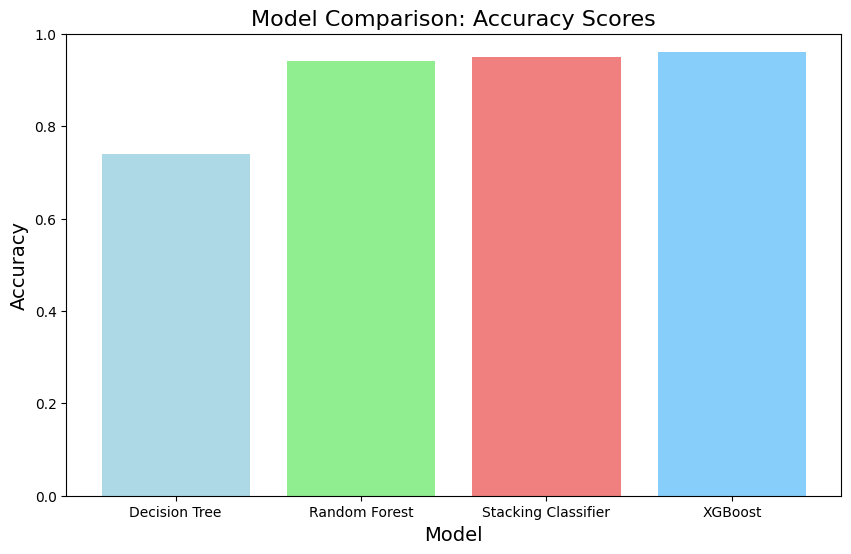

In [733]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and accuracies for comparison
models = ['Decision Tree', 'Random Forest', 'Stacking Classifier', 'XGBoost']
accuracies = [0.74, 0.94, 0.95, 0.96]

# Create a bar plot for model comparison
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Model Comparison: Accuracy Scores', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.show()

# # Model saving

In [734]:
import joblib

joblib.dump(dt_model, 'Models/Decision_Tree.pkl')
joblib.dump(rf_model, 'Models/Random_Forest.pkl')
joblib.dump(sc_model, 'Models/Stacking_Classifier.pkl')
joblib.dump(xgb_model, 'Models/XGBoost.pkl')

['Models/XGBoost.pkl']

# # Model Prediction part

Mapping for column 'InputType':
* Label 0: Constant
* Label 1: Random
* Label 2: Reverse Sorted
* Label 3: Sorted

Mapping for column 'STSclass':
* Label 0: Long burst
* Label 1: Medium burst
* Label 2: Short burst
* Label 3: Very long burst
* Label 4: Very short burst

The **STS_Class** (Special Time Slice Class) is the **classification label**:

| Class | CPU Burst Time (Ticks) | Description                                                   |
|-------|------------------------|---------------------------------------------------------------|
| Very short burst     | 0–99 ticks             | Suitable for I/O-bound or highly interactive tasks. |
| Short burst     | 100–199 ticks          | Ideal for lightweight CPU tasks with frequent preemption. |
| Medium burst     | 200–299 ticks          | Balanced for mixed CPU/I/O workloads.  |
| Long burst     | 300–399 ticks          | For CPU-intensive tasks needing sustained execution. |
| Very long burst     | 400–500 ticks          | Reserved for heavy CPU-bound processes. |

In [750]:
# Load the model from the file
import joblib
model = joblib.load(r'Models\XGBoost.pkl')

prediction_labels = {
    0: ["Long burst", "300–399 ticks", "For CPU-intensive tasks needing sustained execution"],
    1: ["Medium burst", "200–299 ticks", "Balanced for mixed CPU/I/O workloads"],
    2: ["Short burst", "100–199 ticks", "Ideal for lightweight CPU tasks with frequent preemption"],
    3: ["Very long burst", "400–500 ticks", "Reserved for heavy CPU-bound processes"],
    4: ["Very short burst", "0–99 ticks", "Suitable for I/O-bound or highly interactive tasks"]
}

def prediction_func(input_data):
    prediction = model.predict([input_data])
    result = prediction_labels[prediction[0]]
    print("Predicted Class : ", result[0])
    print("Predicted CPU Burst Time (Ticks) : ", result[1])
    print("Description : ", result[2])

### Example Prediction

In [751]:
prediction_func([5834, 11138, 473, 592, 46174, 0])

Predicted Class :  Long burst
Predicted CPU Burst Time (Ticks) :  300–399 ticks
Description :  For CPU-intensive tasks needing sustained execution


In [752]:
prediction_func([5490, 19840, 748, 4880, 21996, 3])

Predicted Class :  Medium burst
Predicted CPU Burst Time (Ticks) :  200–299 ticks
Description :  Balanced for mixed CPU/I/O workloads


In [753]:
prediction_func([7370, 7851, 19, 4492, 18371, 2])

Predicted Class :  Short burst
Predicted CPU Burst Time (Ticks) :  100–199 ticks
Description :  Ideal for lightweight CPU tasks with frequent preemption


In [754]:
prediction_func([4526, 44824, 592, 4086, 41873, 2])

Predicted Class :  Very long burst
Predicted CPU Burst Time (Ticks) :  400–500 ticks
Description :  Reserved for heavy CPU-bound processes


In [755]:
prediction_func([289, 5247, 405, 461, 11428, 2])

Predicted Class :  Very short burst
Predicted CPU Burst Time (Ticks) :  0–99 ticks
Description :  Suitable for I/O-bound or highly interactive tasks
